In [2]:
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt 
from plot_function import *
from itertools import cycle
from pathlib import Path
from datetime import date

In [3]:
connection = sqlite3.connect('./sample_database.db')
c = connection.cursor()

# Extract data from database

In [4]:
TC_fit = pd.read_sql_query("""SELECT * FROM tc_fit_results""", con=connection)
amp_sweeps = pd.read_sql_query("""SELECT * FROM amp_sweep_info""", con=connection)
solvents = pd.read_sql_query("SELECT * FROM solvent_infos", con=connection)
dilu = pd.read_sql_query("""SELECT sample_prep_info.*, 
                                   dilution_series.dilution_serie
                            FROM sample_prep_info
                            LEFT JOIN dilution_series USING (sample_ID)
                         """, con=connection)
frq_sweeps = pd.read_sql("select * from frq_sweep_info", con=connection)
flow_curves = pd.read_sql("select * from flow_curves", con=connection)

# Plot the concentration sweep

In [5]:
flow_curves = pd.merge(left=flow_curves, right=dilu, how='left', on=['sample_ID'])
flow_curves_concentration_sweep = flow_curves[flow_curves.dilution_serie == 'carbopol~974p~in~propylenglycol']

df20 = flow_curves_concentration_sweep[flow_curves_concentration_sweep.temperature == 20]
df20 = df20.sort_values('w_percent', ascending=False)

name,TC_eta_bg,TC_gammadot_crit,TC_ystress,AIC
key,,,,
1.3,0.307,0.000,0.001,460.270
1.5,0.397,0.000,0.002,539.734
1.7,0.449,0.000,0.003,187.440
1.75,0.466,0.000,0.005,-6.878
1.78,0.450,0.021,2.237,1.069
1.8,0.485,0.019,2.599,-45.003
1.85,0.478,0.068,5.071,-74.010
1.9,0.459,0.025,3.205,374.841
2.0,0.493,0.151,10.037,218.437


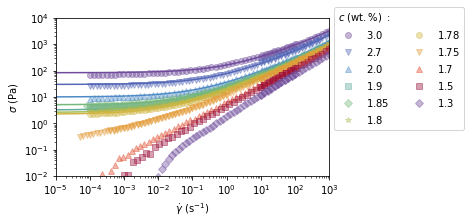

In [6]:
import rheofit
TC_model=rheofit.models.TC_model


fig, ax, color, marker = create_plot()
x = np.logspace(-5, 3, 30)
c_for_TC=[3.0,2.7,2.0,1.9,1.85,1.8, 1.78]

import pybroom
res_fit_dict={}
AIC_list=[]
for c, dfh in df20.groupby('w_percent', sort=False):
    col=next(color)
    ax.loglog(dfh.shear_rate, dfh.shear_stress, c=col, mfc=col, alpha=0.4, marker=next(marker), label=f'${c}$', linestyle='none')
    res_fit_dict[c]=TC_model.fit(dfh.shear_stress,x=dfh.shear_rate)
    AIC_list.append(res_fit_dict[c].aic)
    if c in c_for_TC:
        plt.plot(x, res_fit_dict[c].eval(x=x), color=col)
     

    
res_table=pybroom.tidy(res_fit_dict)
TC_fit_table=res_table.pivot(index='key',columns='name',values='value')
TC_fit_table['AIC']=AIC_list

ax.legend(title='$c~(\mathrm{wt.}\%)~:$', bbox_to_anchor=(1, 1.1), ncol=2)._legend_box.align='left'
ax.set(xlim=(1e-5, 1e3), ylim=(1e-2, 1e4))
ax.set(xlabel='$\dot{\gamma}~(\mathrm{s}^{-1})$', 
       ylabel='$\sigma~\mathrm{(Pa)}$', 
      xticks=[1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1000], 
      yticks=[0.01, 0.1, 1, 10, 100, 1000, 10000])
fig.savefig('./figures_marco/concentration_sweep.svg')
TC_fit_table.round(3)



In [7]:
res_fit_dict_HB={}
AIC_list=[]
for c, dfh in df20.groupby('w_percent', sort=False):
    col=next(color)
    ax.loglog(dfh.shear_rate, dfh.shear_stress, c=col, mfc=col, alpha=0.4, marker=next(marker), label=f'${c}$', linestyle='none')
    res_fit_dict_HB[c]=rheofit.models.HB_model.fit(dfh.shear_stress,x=dfh.shear_rate)
    AIC_list.append(res_fit_dict_HB[c].aic)
res_table=pybroom.tidy(res_fit_dict_HB)
HB_fit_table=res_table.pivot(index='key',columns='name',values='value')
HB_fit_table['AIC']=AIC_list
HB_fit_table.round(3)

name,HB_K,HB_n,HB_ystress,AIC
key,,,,
1.3,2.088,0.770,0.048,496.820
1.5,4.229,0.725,0.856,587.324
1.7,4.742,0.727,1.887,316.831
1.75,8.935,0.671,2.010,250.423
1.78,10.734,0.635,4.644,196.189
1.8,13.429,0.623,5.309,148.454
1.85,14.301,0.616,7.669,159.230
1.9,12.754,0.643,7.643,373.871
2.0,17.429,0.622,15.349,253.925


# TC Parameters for concentration sweep

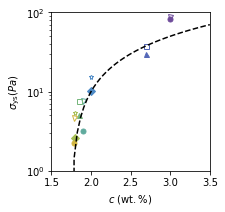

In [8]:
fig, ax, color, marker = create_plot(two_sided=True)

for conc in c_for_TC:
    c = next(color)
    ax.plot(conc, TC_fit_table['TC_ystress'][conc], c=c, mfc=c, marker=next(marker), ms=5)
    ax.plot(conc, HB_fit_table['HB_ystress'][conc], c=c, mfc='None', marker=next(marker), ms=5)

ax.plot(np.linspace(1.5,3.5),40*(np.linspace(1.5,3.5)-1.75), linestyle='--', color='black')

ax.set(xlim=(1.5, 3.5), ylim=(1, 100), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\sigma_\mathrm{ys}{(Pa)}$'
      )

fig.savefig('./figures_marco/concentration_sweep_parameters/ys.svg')

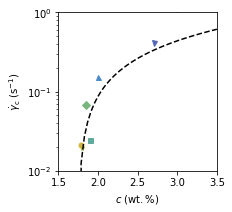

In [9]:
fig, ax, color, marker = create_plot(two_sided=True)

for conc in c_for_TC:
    c = next(color)
    ax.plot(conc, TC_fit_table['TC_gammadot_crit'][conc], c=c, mfc=c, marker=next(marker), ms=5)
    
ax.plot(np.linspace(1.5,3.5),0.35*(np.linspace(1.5,3.5)-1.75), linestyle='--', color='black')


ax.set(xlim=(1.5, 3.5), ylim=(1e-2, 1), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\dot{\gamma}_\mathrm{c}~\mathrm{(s^{-1})}$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/gammadotcrit.svg')

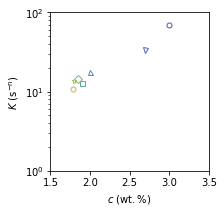

In [10]:
fig, ax, color, marker = create_plot(two_sided=True)

for conc in c_for_TC:
    c = next(color)
    ax.plot(conc, HB_fit_table['HB_K'][conc], c=c, mfc='none', marker=next(marker), ms=5)
    


ax.set(xlim=(1.5, 3.5), ylim=(1, 100), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$K~\mathrm{(s^{-n})}$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/k.svg')

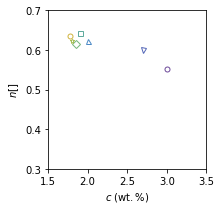

In [11]:
fig, ax, color, marker = create_plot(two_sided=True)

for conc in c_for_TC:
    c = next(color)
    ax.plot(conc, HB_fit_table['HB_n'][conc], c=c, mfc='none', marker=next(marker), ms=5)
    


ax.set(xlim=(1.5, 3.5), ylim=(0.3, 0.7), 
       yscale='linear',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$n []$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/n.svg')

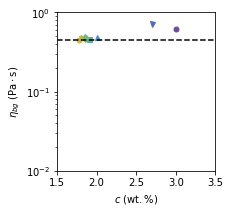

In [12]:
fig, ax, color, marker = create_plot(two_sided=True)

for conc in c_for_TC:
    c = next(color)
    ax.plot(conc, TC_fit_table['TC_eta_bg'][conc], c=c, mfc=c, marker=next(marker), ms=5)

ax.axhline(0.45, linestyle='--', color='black')

ax.set(xlim=(1.5, 3.5), ylim=(0.01, 1), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\eta_{bg}~\mathrm{(Pa \cdot s)}$'
      )

fig.savefig('./figures_marco/concentration_sweep_parameters/viscinf.svg')

# Effect of temperature 

In [14]:
TC_fit = pd.read_sql_query("""SELECT * FROM tc_fit_results""", con=connection)
amp_sweeps = pd.read_sql_query("""SELECT * FROM amp_sweep_info""", con=connection)
solvents = pd.read_sql_query("SELECT * FROM solvent_infos", con=connection)
dilu = pd.read_sql_query("""SELECT sample_prep_info.*, 
                                   dilution_series.dilution_serie
                            FROM sample_prep_info
                            LEFT JOIN dilution_series USING (sample_ID)
                         """, con=connection)
frq_sweeps = pd.read_sql("select * from frq_sweep_info", con=connection)
flow_curves = pd.read_sql("select * from flow_curves", con=connection)
sample=pd.read_sql("select * from tc_fit_results", con=connection)

df = pd.merge(left=sample, right=amp_sweeps, on=['sample_ID', 'temperature'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
df = pd.merge(left=df, right=dilu, on=['sample_ID'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
df = pd.merge(left=df, right=solvents, on=['solvent', 'temperature'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')


marco_visc = pd.read_csv('visc_pg_from_Marco.txt', sep='\t')
marco_visc['round_temperature'] = round(marco_visc.Temperature)
marco_visc['roundtemperature'] = round(marco_visc.Temperature)

visc_round = marco_visc.groupby('round_temperature')['Viscosity'].mean()

PG = solvents.query("solvent == 'propylenglycol'")
PG = PG.sort_values('temperature')

10.0
0.10205033333333334
15.0
0.07533733333333333
20.0
0.05479937142857143
25.0
0.04025268333333334
30.0
0.0305657
35.0
0.023787283333333336
40.0
0.01861688
45.0
0.0150264
50.0
0.01225682857142857


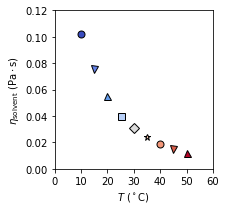

In [15]:
fig, ax, _, marker = create_plot(two_sided=True)
dict_colors = {10: '#3a4cbf', 15: '#6281e9', 20: '#629ae9',
               25: '#b7cff7', 30:'#dbdbdb', 35: '#f3c3ab', 
               40: '#f39779', 45: '#db5e4a', 50: '#b30426'
                }
for T in np.linspace(10, 50, 9):
    print(T)
    print(visc_round[T])
    ax.plot(T, visc_round[T], c='k', ls='--', mfc=dict_colors[T], marker=next(marker), ms=7)
ax.set(xlim=(0, 60), ylim=(0, 0.12), 
       xticks=[0, 10, 20, 30, 40, 50, 60],
       xlabel='$T~(^\circ \mathrm{C})$', ylabel='$\eta_\mathrm{solvent}~\mathrm{(Pa \cdot s)}$')
fig.savefig('solvent_visc.svg', bbox_inches = 'tight')

In [16]:
df_temp = flow_curves_concentration_sweep[flow_curves_concentration_sweep.w_percent == 1.9]

In [17]:
res_fit_dict_HB={}
AIC_list=[]
for c, dfh in df_temp.groupby('temperature', sort=False):
    col=next(color)
    ax.loglog(dfh.shear_rate, dfh.shear_stress, c=col, mfc=col, alpha=0.4, marker=next(marker), label=f'${c}$', linestyle='none')
    res_fit_dict_HB[c]=rheofit.models.HB_model.fit(dfh.shear_stress,x=dfh.shear_rate)
    AIC_list.append(res_fit_dict_HB[c].aic)
res_table=pybroom.tidy(res_fit_dict_HB)
HB_fit_table=res_table.pivot(index='key',columns='name',values='value')
HB_fit_table['AIC']=AIC_list

HB_fit_table_T=HB_fit_table.round(3)
HB_fit_table_T

name,HB_K,HB_n,HB_ystress,AIC
key,,,,
10,17.746,0.672,11.459,336.203
15,14.753,0.658,9.193,291.266
20,12.754,0.643,7.643,250.423
25,11.265,0.629,6.458,205.893
30,9.959,0.618,5.628,162.138
35,8.922,0.608,4.988,117.217
40,7.963,0.601,4.547,68.839
45,7.307,0.594,4.532,30.284
50,6.648,0.589,4.251,-3.378


In [18]:
res_fit_dict_TC={}
AIC_list=[]
for c, dfh in df_temp.groupby('temperature', sort=False):
    col=next(color)
    ax.loglog(dfh.shear_rate, dfh.shear_stress, c=col, mfc=col, alpha=0.4, marker=next(marker), label=f'${c}$', linestyle='none')
    res_fit_dict_TC[c]=rheofit.models.TC_model.fit(dfh.shear_stress,x=dfh.shear_rate)
    AIC_list.append(res_fit_dict_TC[c].aic)
res_table=pybroom.tidy(res_fit_dict_TC)
TC_fit_table=res_table.pivot(index='key',columns='name',values='value')
TC_fit_table['AIC']=AIC_list
TC_fit_table_T=TC_fit_table.round(3)
TC_fit_table_T

name,TC_eta_bg,TC_gammadot_crit,TC_ystress,AIC
key,,,,
10,0.902,0.013,3.551,86.742
15,0.637,0.018,3.336,12.400
20,0.459,0.025,3.205,-6.878
25,0.340,0.030,3.003,-10.142
30,0.258,0.038,2.893,-16.746
35,0.200,0.047,2.775,-14.552
40,0.160,0.058,2.708,-8.810
45,0.132,0.079,2.849,-10.308
50,0.110,0.103,2.903,-18.199


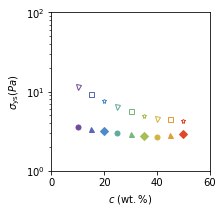

In [19]:
fig, ax, color, marker = create_plot(two_sided=True)

for T in TC_fit_table.index:
    c = next(color)
    ax.plot(T, TC_fit_table['TC_ystress'][T], c=c, mfc=c, marker=next(marker), ms=5)
    ax.plot(T, HB_fit_table['HB_ystress'][T], c=c, mfc='None', marker=next(marker), ms=5)


ax.set(xlim=(0, 60), ylim=(1, 100), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\sigma_\mathrm{ys}{(Pa)}$'
      )

fig.savefig('./figures_marco/concentration_sweep_parameters/ys_T.svg')

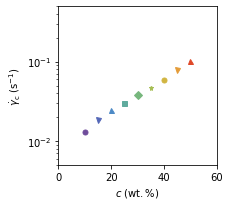

In [20]:
fig, ax, color, marker = create_plot(two_sided=True)

for T in TC_fit_table.index:
    c = next(color)
    ax.plot(T, TC_fit_table['TC_gammadot_crit'][T], c=c, mfc=c, marker=next(marker), ms=5)
    


ax.set(xlim=(0, 60), ylim=(5e-3, 0.5), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\dot{\gamma}_\mathrm{c}~\mathrm{(s^{-1})}$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/gammadotcrit_T.svg')

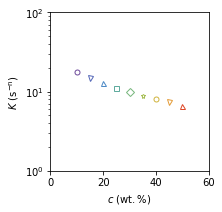

In [21]:
fig, ax, color, marker = create_plot(two_sided=True)

for T in TC_fit_table.index:
    c = next(color)
    ax.plot(T, HB_fit_table['HB_K'][T], c=c, mfc='none', marker=next(marker), ms=5)
    


ax.set(xlim=(0, 60), ylim=(1, 100), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$K~\mathrm{(s^{-n})}$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/k_T.svg')

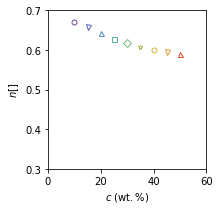

In [22]:
fig, ax, color, marker = create_plot(two_sided=True)

for T in TC_fit_table.index:
    c = next(color)
    ax.plot(T, HB_fit_table['HB_n'][T], c=c, mfc='none', marker=next(marker), ms=5)
    


ax.set(xlim=(0, 60), ylim=(0.3, 0.7), 
       yscale='linear',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$n []$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/n_T.svg')

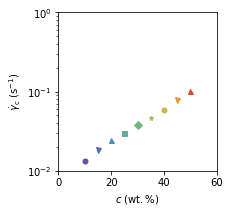

In [23]:
fig, ax, color, marker = create_plot(two_sided=True)

for T in TC_fit_table.index:
    c = next(color)
    ax.plot(T, TC_fit_table['TC_gammadot_crit'][T], c=c, mfc=c, marker=next(marker), ms=5)
    


ax.set(xlim=(0, 60), ylim=(1e-2, 1), 
       yscale='log',
       xlabel='$c~(\mathrm{wt.}\%)$',
       ylabel='$\dot{\gamma}_\mathrm{c}~\mathrm{(s^{-1})}$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/gammadotcrit_T.svg')

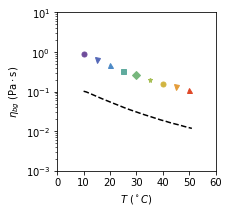

In [24]:
fig, ax, color, marker = create_plot(two_sided=True)

for T in TC_fit_table.index:
    c = next(color)
    ax.plot(T, TC_fit_table['TC_eta_bg'][T], c=c, mfc=c, marker=next(marker), ms=5)

ax.plot(visc_round.iloc[:42], ls='--', color='black')
    


ax.set(ylim=(0.001, 10), 
       yscale='log',
       xlim=(0, 60), 
       xticks=[0, 10, 20, 30, 40, 50, 60],
       xlabel='$T~(^\circ C)$', 
       ylabel='$\eta_{bg}~(\mathrm{Pa \cdot s})$'
      )
fig.savefig('./figures_marco/concentration_sweep_parameters/visc_T.svg')